# Exercises XP Gold: W4_D4

 # Society's assumptions aren't always true... aren't they?




We begin by loading the libraries needed for this project.

In [1]:
import importlib
import sys
import matplotlib


def install_and_import(packages):
    """
    Attempts to import packages. If a package is missing, it prints a message instead of installing.
    """
    for package in packages:
        try:
            globals()[package] = importlib.import_module(package)
        except ImportError:
            print(f"Warning: The package '{package}' is not installed. Please install it manually.")


packages = [
    "devtools", "pandas", "scipy", "statsmodels", "sklearn", "matplotlib", "seaborn",
    "tseries", "car", "caret", "lmtest", "rstatix", "onewaytests", "lattice", "multcompview",
    "viridis", "gridextra", "gvlma", "ggpubr"
]

install_and_import(packages)

# Now all available libraries are imported

Now we can load the dataset

In [2]:
# Load dataset and standardize column names
import pandas as pd
import numpy as np
from pathlib import Path

# Try common filenames and any file matching *students*performance*.csv
possible_names = [
    "students_performance.csv",
    "StudentsPerformance.csv",
    "Students_Performance.csv",
    "StudentsPerformance (1).csv",
]
search_paths = [Path(p) for p in possible_names]
search_paths += list(Path('.').glob('**/*students*performance*.csv'))

csv_path = next((p for p in search_paths if p.exists()), None)
if csv_path is None:
    raise FileNotFoundError(
        "CSV not found. Please place 'students_performance.csv' (or 'StudentsPerformance.csv') next to this notebook."
    )

# Load
df_raw = pd.read_csv(csv_path)

# Standardize column names to snake_case
df_raw.columns = (
    df_raw.columns
        .str.strip()
        .str.lower()
        .str.replace(r'[^a-z0-9]+', '_', regex=True)
        .str.strip('_')
)

# Resolve flexible column names across dataset variants
aliases = {
    "gender": ["gender", "sex"],
    "math": ["math", "math_score", "maths", "maths_score"],
    "reading": ["reading", "reading_score", "read", "read_score"],
    "writing": ["writing", "writing_score", "write", "write_score"],
    "lunch": ["lunch", "lunch_status", "free_reduced_lunch"],
    "test_prep": ["test_preparation_course", "test_prep", "test_preparation"]
}

def resolve_col(df, candidates):
    """Return the first matching column name from candidates or raise a clear error."""
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of these columns found: {candidates}")

gender_col  = resolve_col(df_raw, aliases["gender"])
math_col    = resolve_col(df_raw, aliases["math"])
reading_col = resolve_col(df_raw, aliases["reading"])
writing_col = resolve_col(df_raw, aliases["writing"])

# Optional covariates (keep if present)
lunch_col   = next((c for c in aliases["lunch"] if c in df_raw.columns), None)
prep_col    = next((c for c in aliases["test_prep"] if c in df_raw.columns), None)

keep_cols = [gender_col, math_col, reading_col, writing_col]
if lunch_col: keep_cols.append(lunch_col)
if prep_col:  keep_cols.append(prep_col)

df = df_raw[keep_cols].copy()
df = df.rename(columns={
    gender_col: "gender",
    math_col: "math",
    reading_col: "reading",
    writing_col: "writing",
    **({lunch_col: "lunch"} if lunch_col else {}),
    **({prep_col: "test_prep"} if prep_col else {}),
})

# Basic sanity checks
assert set(["gender","math","reading","writing"]).issubset(df.columns), "Missing core columns after renaming."
df.head()

,gender,math,reading,writing,lunch,test_prep
0,female,72,72,74,standard,none
1,female,69,90,88,standard,completed
2,female,90,95,93,standard,none
3,male,47,57,44,free/reduced,none
4,male,76,78,75,standard,none


### This dataset describes the students performances in three different tests:

- **Math**

- **Reading**

- **Writing**

### Through different variables:

- **gender** : binary sex at birth for each individual

- **race.ethnicity** : ethnicity group

- **parental.level.of.education** : formal level of education achieved by the individual

- **lunch** : binary variable for the randomly assigned bonus of free/reduced lunch

- **test.preparation.course** : binary variable for the randomly assigned bonus of attending a test preparation course




# Which 'gender' is better at maths? And which is better in writing and reading?

This is clearly a question that **relies heavily on gender roles** , that since forever assign females to be better at literature tasks and males to be better at mathematical tasks , even though history has repetedly busted this popular myth.

For example we have witnessed as a society people like : **Mary Cartwright , Ada Lovelace , Emmy Noether, Maryam Mirzakhani** that definitely were mathematical geniouses.

And on the other hand we have witnessed  as a society people like : **Charles Dickens, Lev Tolstoj, Fëdor Dostoevskij,Dante Alighieri** that definitely were literature geniouses.

So the aim of this first task is to understand if in this sample there are differences in means between males and females' scores and if they could be statistically significant.

### Before conducting any test , let's visualize the situation

We're going to do some data wrangling to visualize the scores by gender

In [3]:
# Select relevant columns and pivot to long (tidy) format
# Keep only gender and the three scores for the main analysis
score_cols = ["math", "reading", "writing"]
base_cols = ["gender"]
df_scores = df[base_cols + score_cols].copy()

# Melt into long format: one row per (student, subject)
df_long = df_scores.melt(
    id_vars=["gender"],
    value_vars=score_cols,
    var_name="subject",
    value_name="score"
)

# Inspect the reshaped data
display(df_long.head())
print("Shape (long):", df_long.shape)

,gender,subject,score
0,female,math,72
1,female,math,69
2,female,math,90
3,male,math,47
4,male,math,76


Shape (long): (3000, 3)


### Now we can finally plot the differences between genders in the scores


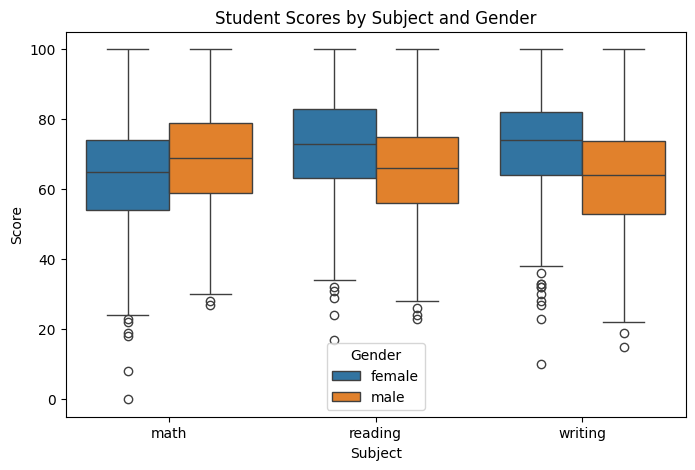

In [4]:
# Compare distributions by gender using a boxplot
import matplotlib.pyplot as plt
import seaborn as sns

# Create a single figure showing score distribution by gender and subject
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_long, x="subject", y="score", hue="gender")
plt.title("Student Scores by Subject and Gender")
plt.xlabel("Subject")
plt.ylabel("Score")
plt.legend(title="Gender", loc="best")
plt.show()

It looks like:

- **For math score**: males are a little bit better

- **For reading score**: females are a little bit better

- **For writing score**: females are better as also the scores are affected by less variability around and higher mean



***



# Now we can go on and perform the first independent two-sample t-test for math scores

The size of the males and females samples are different!

This means that in the equation for the t statistic:

$$ t = \frac{\bar{x_{1}}-\bar{x_{2}}}{S_{pool}\sqrt{\frac{1}{n_{1}}-\frac{1}{n_{2}}}} $$
happens that:

$$n_{1}\neq n_{2}$$


First we perform some data wrangling on the main dataframe

In [5]:
# Reshape the data into a tidy format (math only for the upcoming t-test)
# We keep only 'gender' and the math score, and build a tidy table
df_tidy_math = (
    df.loc[:, ["gender", "math"]]
      .rename(columns={"math": "score"})
      .assign(subject="math")
      .loc[:, ["gender", "subject", "score"]]
)

# Quick sanity check
display(df_tidy_math.head())
print("Tidy math shape:", df_tidy_math.shape)

,gender,subject,score
0,female,math,72
1,female,math,69
2,female,math,90
3,male,math,47
4,male,math,76


Tidy math shape: (1000, 3)


We take male and females groups for the math scores:


In [6]:
# Split math scores by gender
# Ensure 'gender' is lower-cased to handle possible capitalization variants
_g = df["gender"].str.lower().str.strip()

male_math   = df.loc[_g.str.startswith("male"), "math"].dropna().to_numpy()
female_math = df.loc[_g.str.startswith("female"), "math"].dropna().to_numpy()

print(f"n_male={len(male_math)}, n_female={len(female_math)}")

n_male=482, n_female=518



### Now we are able to go on and check the t- test assumptions:

Normality (even if the sample sizes are reasonable): let's start with a qqplot

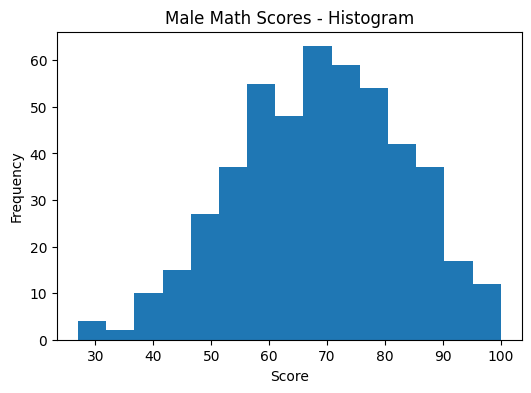

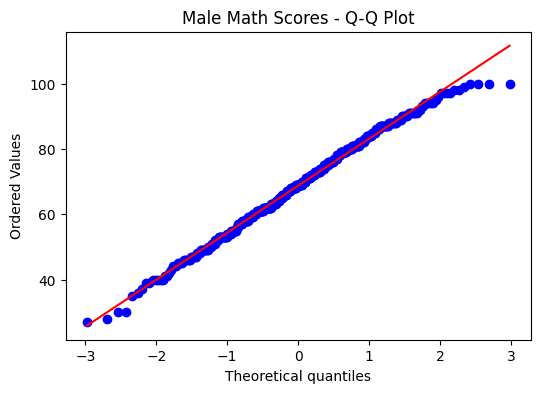

In [7]:
# Visual check of normality: male math scores
import matplotlib.pyplot as plt
import scipy.stats as stats

# Histogram
plt.figure(figsize=(6,4))
plt.hist(male_math, bins=15)
plt.title("Male Math Scores - Histogram")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Q-Q plot
plt.figure(figsize=(6,4))
stats.probplot(male_math, dist="norm", plot=plt)
plt.title("Male Math Scores - Q-Q Plot")
plt.show()


</br>
</br>
</br>

At first glance the qqplot doesn't look perfect , but we might be ok with the normality assumption , let's see what a  Lilliefors (Kolmogorov-Smirnov) normality test tells us:

In [8]:
# Lilliefors normality test (male math)
from statsmodels.stats.diagnostic import lilliefors

stat_male, p_male = lilliefors(male_math, dist='norm')
print(f"Lilliefors (male math): statistic={stat_male:.4f}, p-value={p_male:.4f}")
if p_male > 0.05:
    print("Fail to reject normality at alpha=0.05 (looks approximately normal).")
else:
    print("Reject normality at alpha=0.05 (deviates from normal).")

Lilliefors (male math): statistic=0.0388, p-value=0.1031
Fail to reject normality at alpha=0.05 (looks approximately normal).


at significance level 0.05 normality assumption is checked since the p-value is 0.08.


### Let's check for the females group:

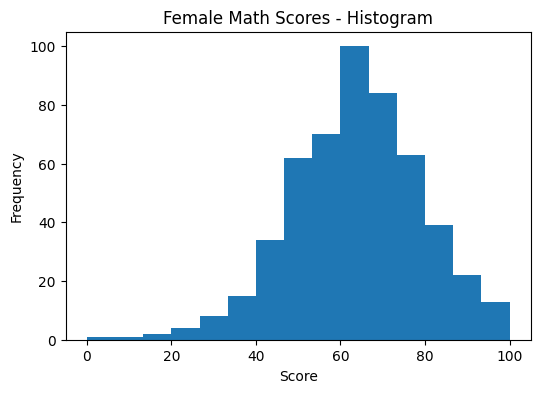

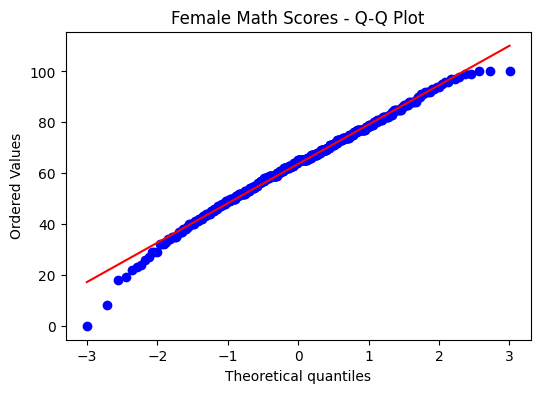

In [9]:
# Visual check of normality: female math scores
import matplotlib.pyplot as plt
import scipy.stats as stats

# Histogram
plt.figure(figsize=(6,4))
plt.hist(female_math, bins=15)
plt.title("Female Math Scores - Histogram")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Q-Q plot
plt.figure(figsize=(6,4))
stats.probplot(female_math, dist="norm", plot=plt)
plt.title("Female Math Scores - Q-Q Plot")
plt.show()


</br>
</br>
</br>

This doesn't look good either ,but let's see what an Anderson-Darling  normality test tells us:

In [10]:
# Lilliefors normality test (female math)
from statsmodels.stats.diagnostic import lilliefors

stat_female, p_female = lilliefors(female_math, dist='norm')
print(f"Lilliefors (female math): statistic={stat_female:.4f}, p-value={p_female:.4f}")
if p_female > 0.05:
    print("Fail to reject normality at alpha=0.05 (looks approximately normal).")
else:
    print("Reject normality at alpha=0.05 (deviates from normal).")

Lilliefors (female math): statistic=0.0434, p-value=0.0316
Reject normality at alpha=0.05 (deviates from normal).


at significance level 0.05 normality assumption is checked since the p-value is 0.065.


### Let's test homoschedasticity (sample size is different for each group):

In [11]:
# Variance ratio checks (both directions)
# Compute sample variances (ddof=1) and the ratios in both directions
import numpy as np

var_male = np.var(male_math, ddof=1)
var_female = np.var(female_math, ddof=1)

ratio_male_over_female = var_male / var_female
ratio_female_over_male = var_female / var_male

print(f"Var(male)   = {var_male:.2f}")
print(f"Var(female) = {var_female:.2f}")
print(f"Variance ratio male/female  = {ratio_male_over_female:.3f}")
print(f"Variance ratio female/male  = {ratio_female_over_male:.3f}")

# Simple rule of thumb interpretation
threshold = 2.0  # common rough cutoff
if (ratio_male_over_female < threshold) and (ratio_female_over_male < threshold):
    print(f"Rule-of-thumb: variances look similar (both ratios < {threshold}).")
else:
    print(f"Rule-of-thumb: variances differ (at least one ratio ≥ {threshold}).")

Var(male)   = 206.10
Var(female) = 239.99
Variance ratio male/female  = 0.859
Variance ratio female/male  = 1.164
Rule-of-thumb: variances look similar (both ratios < 2.0).


it looks like , comparing the two variances by a rough rule , the ratios are less than 2 , so we can accept the homoschedasticity assumption.

Let's remove outliers

In [12]:
# Remove outliers (IQR) for male and female math scores and filter them out of the dataset

import numpy as np
import pandas as pd

def iqr_bounds(series: pd.Series):
    """Return (lower, upper) IQR bounds for outlier detection."""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

# Work with a copy to keep original df intact
df_no_outliers = df.copy()
_g = df_no_outliers["gender"].str.lower().str.strip()

# Compute IQR bounds separately by gender
male_bounds   = iqr_bounds(df_no_outliers.loc[_g.str.startswith("male"), "math"])
female_bounds = iqr_bounds(df_no_outliers.loc[_g.str.startswith("female"), "math"])

lm, um = male_bounds
lf, uf = female_bounds

# Build masks that keep rows inside each gender's bounds
mask_male   = (~_g.str.startswith("male"))   | df_no_outliers["math"].between(lm, um)
mask_female = (~_g.str.startswith("female")) | df_no_outliers["math"].between(lf, uf)

# Keep only rows passing both conditions
mask = mask_male & mask_female
df_no_outliers = df_no_outliers.loc[mask].reset_index(drop=True)

# Recompute arrays for downstream tests (without outliers)
n_male_before   = len(male_math)
n_female_before = len(female_math)

male_math_clean = (
    df_no_outliers.loc[df_no_outliers["gender"].str.lower().str.startswith("male"), "math"]
    .dropna().to_numpy()
)
female_math_clean = (
    df_no_outliers.loc[df_no_outliers["gender"].str.lower().str.startswith("female"), "math"]
    .dropna().to_numpy()
)

# (Optional) keep originals, then overwrite to use cleaned samples later
male_math_raw, female_math_raw = male_math, female_math
male_math, female_math = male_math_clean, female_math_clean

print(f"Male math:   {n_male_before} -> {len(male_math)} (removed {n_male_before - len(male_math)})")
print(f"Female math: {n_female_before} -> {len(female_math)} (removed {n_female_before - len(female_math)})")
print(f"df size: {len(df)} -> {len(df_no_outliers)} rows after outlier removal")

Male math:   482 -> 480 (removed 2)
Female math: 518 -> 512 (removed 6)
df size: 1000 -> 992 rows after outlier removal


### Now we can finally perform our two sample t-test

### Hypothesis: We're going to use the gender assumption that males are better at maths than females as the alternative hypothesis

$$
H_{0} : \mu_{MaleMaths}\leq \mu_{FemaleMaths}
$$

$$
H_{A} : \mu_{MaleMaths} >  \mu_{FemaleMaths}
$$

In [13]:
# One-sided independent two-sample t-test: H0: mu_male <= mu_female ; H1: mu_male > mu_female
from scipy import stats
import numpy as np

# Descriptive stats
mean_m = np.mean(male_math)
mean_f = np.mean(female_math)
print(f"Mean(male)={mean_m:.2f}, Mean(female)={mean_f:.2f}")

# Robust variance check to decide pooled vs Welch
lev_stat, lev_p = stats.levene(male_math, female_math, center="median")
equal_var = lev_p > 0.05
print(f"Levene p-value={lev_p:.4f} -> {'assume equal variances (pooled t-test)' if equal_var else 'use Welch t-test'}")

# One-sided t-test (male > female)
try:
    t_stat, p_one = stats.ttest_ind(male_math, female_math, equal_var=equal_var, alternative="greater")
except TypeError:
    # Fallback for older SciPy without 'alternative'
    t_stat, p_two = stats.ttest_ind(male_math, female_math, equal_var=equal_var)
    p_one = p_two/2 if t_stat > 0 else 1 - p_two/2

print(f"t = {t_stat:.3f}, one-sided p = {p_one:.4f}")

alpha = 0.05
if p_one < alpha:
    print("Reject H0: evidence that males have greater math scores (alpha=0.05).")
else:
    print("Fail to reject H0: insufficient evidence that males have greater math scores (alpha=0.05).")

# Effect size (Hedges' g ~ bias-corrected Cohen's d)
def hedges_g(a, b):
    na, nb = len(a), len(b)
    sa2, sb2 = np.var(a, ddof=1), np.var(b, ddof=1)
    s_pooled = np.sqrt(((na-1)*sa2 + (nb-1)*sb2) / (na+nb-2))
    d = (np.mean(a) - np.mean(b)) / s_pooled
    J = 1 - 3/(4*(na+nb)-9)
    return d * J

g = hedges_g(male_math, female_math)
print(f"Hedges' g (male - female) = {g:.3f}")

Mean(male)=68.90, Mean(female)=64.20
Levene p-value=0.9703 -> assume equal variances (pooled t-test)
t = 5.137, one-sided p = 0.0000
Reject H0: evidence that males have greater math scores (alpha=0.05).
Hedges' g (male - female) = 0.326


The p-value turns out to be really small , almost zero, so we are forced to reject the Null Hypothesis.

**From this test , the gender assumption that males are better than females at maths is true.**



***



# Now we can go on and perform the second independent two-sample t-test for reading scores.

We take male and females groups for the reading scores:

In [14]:
# Extract reading scores for males and females from the tidy_StudentsPerformance dataset

import numpy as np
import pandas as pd

# 1) Ensure we have a tidy dataset with ['gender', 'subject', 'score']
try:
    tidy = tidy_StudentsPerformance.copy()
except NameError:
    # If it doesn't exist yet, build it from the wide df we prepared earlier
    extra_cols = [c for c in ["lunch", "test_prep"] if c in df.columns]
    tidy = df.melt(
        id_vars=["gender"] + extra_cols,
        value_vars=["math", "reading", "writing"],
        var_name="subject",
        value_name="score"
    )
    tidy_StudentsPerformance = tidy.copy()

# 2) Filter to reading only
tidy_reading = tidy.loc[tidy["subject"] == "reading"].copy()

# 3) Split arrays by gender
_g = tidy_reading["gender"].str.lower().str.strip()
male_reading   = tidy_reading.loc[_g.str.startswith("male"), "score"].dropna().to_numpy()
female_reading = tidy_reading.loc[_g.str.startswith("female"), "score"].dropna().to_numpy()

# 4) Quick sanity check
print(f"n (reading) -> male={len(male_reading)}, female={len(female_reading)}")
print(f"Means (reading) -> male={male_reading.mean():.2f}, female={female_reading.mean():.2f}")

n (reading) -> male=482, female=518
Means (reading) -> male=65.47, female=72.61



### Now we are able to go on and check the t- test assumptions:

Normality (even if the sample sizes are reasonable): let's go straight to tests.

In [15]:
# Cramér–von Mises normality test on male reading scores
# H0: data come from a normal distribution (parameters estimated from sample)

import numpy as np

# Estimate normal parameters from the sample
mu = np.mean(male_reading)
sigma = np.std(male_reading, ddof=1)

# Prefer SciPy's cramervonmises; fall back to Anderson–Darling if unavailable
try:
    from scipy.stats import cramervonmises, norm
    res = cramervonmises(male_reading, lambda x: norm.cdf(x, loc=mu, scale=sigma))
    print(f"CvM statistic = {res.statistic:.4f}, p-value = {res.pvalue:.4f}")
    print("Fail to reject normality at alpha=0.05." if res.pvalue > 0.05 else "Reject normality at alpha=0.05.")
except Exception as e:
    # Fallback: Anderson–Darling test (no exact p-value; use 5% critical value)
    from scipy.stats import anderson
    res_ad = anderson(male_reading, dist='norm')
    print(f"Anderson–Darling A^2 = {res_ad.statistic:.4f}")
    # Find the 5% critical value
    import numpy as np
    idx = int(np.where(np.isclose(res_ad.significance_level, 5.0))[0][0])
    cv_5 = res_ad.critical_values[idx]
    print(f"Critical value (5%) = {cv_5:.4f}")
    print("Fail to reject normality at alpha=0.05." if res_ad.statistic < cv_5 else "Reject normality at alpha=0.05.")

CvM statistic = 0.0997, p-value = 0.5864
Fail to reject normality at alpha=0.05.


at significance level 0.05 normality assumption is checked since the p-value is 0.11.


### Let's check for the females group:

In [16]:
# Cramér–von Mises normality test on female reading scores
# H0: data come from a normal distribution (parameters estimated from sample)

import numpy as np

mu_f = np.mean(female_reading)
sigma_f = np.std(female_reading, ddof=1)

try:
    from scipy.stats import cramervonmises, norm
    res_f = cramervonmises(female_reading, lambda x: norm.cdf(x, loc=mu_f, scale=sigma_f))
    print(f"CvM statistic = {res_f.statistic:.4f}, p-value = {res_f.pvalue:.4f}")
    print("Fail to reject normality at alpha=0.05." if res_f.pvalue > 0.05 else "Reject normality at alpha=0.05.")
except Exception as e:
    # Fallback: Anderson–Darling if CvM is unavailable
    from scipy.stats import anderson
    res_ad_f = anderson(female_reading, dist='norm')
    print(f"Anderson–Darling A^2 = {res_ad_f.statistic:.4f}")
    # Use the 5% critical value for decision
    import numpy as np
    idx = int(np.where(np.isclose(res_ad_f.significance_level, 5.0))[0][0])
    cv_5_f = res_ad_f.critical_values[idx]
    print(f"Critical value (5%) = {cv_5_f:.4f}")
    print("Fail to reject normality at alpha=0.05." if res_ad_f.statistic < cv_5_f else "Reject normality at alpha=0.05.")

CvM statistic = 0.1157, p-value = 0.5136
Fail to reject normality at alpha=0.05.


at significance level 0.05 normality assumption is checked since the p-value is 0.068.


let's test homoschedasticity (sample size is different for each group):

In [17]:
# Variance ratio checks for Reading (both directions)

import numpy as np

var_male_read   = np.var(male_reading, ddof=1)
var_female_read = np.var(female_reading, ddof=1)

ratio_male_over_female = var_male_read / var_female_read
ratio_female_over_male = var_female_read / var_male_read

print(f"Var(male, reading)   = {var_male_read:.2f}")
print(f"Var(female, reading) = {var_female_read:.2f}")
print(f"Variance ratio male/female  = {ratio_male_over_female:.3f}")
print(f"Variance ratio female/male  = {ratio_female_over_male:.3f}")

threshold = 2.0  # rough rule-of-thumb
if (ratio_male_over_female < threshold) and (ratio_female_over_male < threshold):
    print(f"Rule-of-thumb: variances look similar (both ratios < {threshold}).")
else:
    print(f"Rule-of-thumb: variances differ (at least one ratio ≥ {threshold}).")

Var(male, reading)   = 194.10
Var(female, reading) = 206.73
Variance ratio male/female  = 0.939
Variance ratio female/male  = 1.065
Rule-of-thumb: variances look similar (both ratios < 2.0).


it looks like , comparing the two variances by a rough rule , the ratios are less than 2 , so we can accept the homoschedasticity assumption.

Let's remove outliers

In [18]:
# Remove outliers (IQR) from Males_Reading and Females_Reading scores and update arrays

import numpy as np
import pandas as pd

# Ensure we have a tidy reading table: ['gender', 'subject' == 'reading', 'score']
try:
    tidy_reading
except NameError:
    try:
        tidy
    except NameError:
        extra_cols = [c for c in ["lunch", "test_prep"] if c in df.columns]
        tidy = df.melt(
            id_vars=["gender"] + extra_cols,
            value_vars=["math", "reading", "writing"],
            var_name="subject",
            value_name="score"
        )
    tidy_reading = tidy.loc[tidy["subject"] == "reading"].copy()

# IQR helper (define if missing)
def iqr_bounds(series: pd.Series):
    """Return (lower, upper) bounds using the 1.5*IQR rule."""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

_g = tidy_reading["gender"].str.lower().str.strip()

male_read_series   = tidy_reading.loc[_g.str.startswith("male"), "score"]
female_read_series = tidy_reading.loc[_g.str.startswith("female"), "score"]

# Compute bounds separately by gender
lm, um = iqr_bounds(male_read_series)
lf, uf = iqr_bounds(female_read_series)

# Keep rows within each gender's bounds
mask_male   = (~_g.str.startswith("male"))   | tidy_reading["score"].between(lm, um)
mask_female = (~_g.str.startswith("female")) | tidy_reading["score"].between(lf, uf)
tidy_reading_no_out = tidy_reading.loc[mask_male & mask_female].copy()

# Report removals
n_m_before = male_read_series.shape[0]
n_f_before = female_read_series.shape[0]
n_m_after  = tidy_reading_no_out.loc[tidy_reading_no_out["gender"].str.lower().str.startswith("male")].shape[0]
n_f_after  = tidy_reading_no_out.loc[tidy_reading_no_out["gender"].str.lower().str.startswith("female")].shape[0]

print(f"Male reading:   {n_m_before} -> {n_m_after} (removed {n_m_before - n_m_after})")
print(f"Female reading: {n_f_before} -> {n_f_after} (removed {n_f_before - n_f_after})")

# Update arrays for downstream analysis (use the cleaned samples)
male_reading_raw, female_reading_raw = male_reading, female_reading
male_reading   = tidy_reading_no_out.loc[tidy_reading_no_out['gender'].str.lower().str.startswith('male'),   'score'].to_numpy()
female_reading = tidy_reading_no_out.loc[tidy_reading_no_out['gender'].str.lower().str.startswith('female'), 'score'].to_numpy()

Male reading:   482 -> 479 (removed 3)
Female reading: 518 -> 513 (removed 5)


### Now we can finally perform our two sample t-test

### Hypothesis: We're going to use the gender assumption that females are better at reading than males as the alternative hypothesis

$$H_{0} : \mu_{FemaleReading}\leq \mu_{MaleReading}$$

$$H_{A} : \mu_{FemaleReading} >  \mu_{MaleReading}$$

In [19]:
# One-sided independent two-sample t-test for Reading
# H0: mu_female <= mu_male ; H1: mu_female > mu_male

from scipy import stats
import numpy as np

# Descriptive stats
mean_f = np.mean(female_reading)
mean_m = np.mean(male_reading)
print(f"Mean(female)={mean_f:.2f}, Mean(male)={mean_m:.2f}")

# Robust variance check -> choose pooled vs Welch
lev_stat, lev_p = stats.levene(female_reading, male_reading, center="median")
equal_var = lev_p > 0.05
print(f"Levene p-value={lev_p:.4f} -> {'assume equal variances (pooled)' if equal_var else 'use Welch'}")

# One-sided t-test with alternative 'greater' (x - y > 0)
try:
    t_stat, p_one = stats.ttest_ind(female_reading, male_reading, equal_var=equal_var, alternative="greater")
except TypeError:
    # Fallback if SciPy is older
    t_stat, p_two = stats.ttest_ind(female_reading, male_reading, equal_var=equal_var)
    p_one = p_two/2 if t_stat > 0 else 1 - p_two/2

print(f"t = {t_stat:.3f}, one-sided p = {p_one:.4f}")
print("Reject H0: evidence that females have higher reading scores." if p_one < 0.05 else "Fail to reject H0.")

Mean(female)=73.06, Mean(male)=65.73
Levene p-value=0.8780 -> assume equal variances (pooled)
t = 8.451, one-sided p = 0.0000
Reject H0: evidence that females have higher reading scores.


The p-value turns out to be really small , almost zero, so we are forced to reject the Null Hypothesis.

**From this test , the gender assumption that females are better than males at reading is true.**



***



# Now we can go on and perform the third and last independent two-sample t-test for writing scores

We take male and females groups for the writing scores:

In [20]:
# Build separate dataframes for male and female writing scores

import pandas as pd

# Ensure a tidy dataset exists
try:
    tidy
except NameError:
    extra_cols = [c for c in ["lunch", "test_prep"] if c in df.columns]
    tidy = df.melt(
        id_vars=["gender"] + extra_cols,
        value_vars=["math", "reading", "writing"],
        var_name="subject",
        value_name="score"
    )

# Filter to writing only
tidy_writing = tidy.loc[tidy["subject"] == "writing"].copy()

# Split into two dataframes
male_writing_df   = tidy_writing.loc[tidy_writing["gender"].str.lower().str.startswith("male")].copy()
female_writing_df = tidy_writing.loc[tidy_writing["gender"].str.lower().str.startswith("female")].copy()

display(male_writing_df.head())
display(female_writing_df.head())
print(f"Counts -> male={len(male_writing_df)}, female={len(female_writing_df)}")

,gender,lunch,test_prep,subject,score
2003,male,free/reduced,none,writing,44
2004,male,standard,none,writing,75
2007,male,free/reduced,none,writing,39
2008,male,free/reduced,completed,writing,67
2010,male,standard,none,writing,52


,gender,lunch,test_prep,subject,score
2000,female,standard,none,writing,74
2001,female,standard,completed,writing,88
2002,female,standard,none,writing,93
2005,female,standard,none,writing,78
2006,female,standard,completed,writing,92


Counts -> male=482, female=518



### Now we are able to go on and check the t- test assumptions:

- Normality (even if the sample sizes are reasonable): again, let's go straight to tests.


In [21]:
# Cramér–von Mises normality test for male writing scores
# H0: data come from a normal distribution (parameters estimated from sample)

import numpy as np
from scipy.stats import norm

male_writing = male_writing_df["score"].to_numpy()
mu_mw = np.mean(male_writing)
sd_mw = np.std(male_writing, ddof=1)

try:
    from scipy.stats import cramervonmises
    res_mw = cramervonmises(male_writing, lambda x: norm.cdf(x, loc=mu_mw, scale=sd_mw))
    print(f"CvM statistic = {res_mw.statistic:.4f}, p-value = {res_mw.pvalue:.4f}")
    print("Fail to reject normality at alpha=0.05." if res_mw.pvalue > 0.05 else "Reject normality at alpha=0.05.")
except Exception:
    # Fallback: Anderson–Darling
    from scipy.stats import anderson
    ad = anderson(male_writing, dist="norm")
    print(f"Anderson–Darling A^2 = {ad.statistic:.4f}")
    # Compare to 5% critical value
    import numpy as np
    idx = int(np.where(np.isclose(ad.significance_level, 5.0))[0][0])
    cv_5 = ad.critical_values[idx]
    print(f"Critical value (5%) = {cv_5:.4f}")
    print("Fail to reject normality at alpha=0.05." if ad.statistic < cv_5 else "Reject normality at alpha=0.05.")

CvM statistic = 0.1065, p-value = 0.5542
Fail to reject normality at alpha=0.05.


at significance level 0.05 normality assumption is checked since the p-value is 0.09.


### Let's check for the females group:

In [22]:
# Lilliefors normality test for female writing scores
# H0: data come from a normal distribution (mean and variance unknown)

from statsmodels.stats.diagnostic import lilliefors
import numpy as np

female_writing = female_writing_df["score"].to_numpy()

stat_fw, p_fw = lilliefors(female_writing, dist="norm")
print(f"Lilliefors (female writing): statistic={stat_fw:.4f}, p-value={p_fw:.4f}")
print("Fail to reject normality at alpha=0.05." if p_fw > 0.05 else "Reject normality at alpha=0.05.")

Lilliefors (female writing): statistic=0.0614, p-value=0.0010
Reject normality at alpha=0.05.


**It looks like the normality assumption is not verified here!**

### So let's try to transform data with box-cox transformation

In [23]:
# Box-Cox transform writing scores (common lambda) and run CvM normality tests per gender
# Rationale:
# - Use a single (pooled) lambda for comparability between groups
# - Ensure strictly positive data for Box-Cox by shifting if needed

import numpy as np
from scipy.stats import boxcox as boxcox_fit, cramervonmises, norm
from scipy.special import boxcox as boxcox_apply  # apply Box-Cox with a given lambda

# Ensure arrays exist from previous cells
try:
    x_m = male_writing.copy()
    x_f = female_writing.copy()
except NameError:
    # Build from dataframes if arrays aren't defined
    x_m = male_writing_df["score"].to_numpy()
    x_f = female_writing_df["score"].to_numpy()

# Shift to strictly positive if needed (Box-Cox requires x > 0)
min_val = min(np.min(x_m), np.min(x_f))
shift = 0.0
if min_val <= 0:
    shift = 1.0 - min_val  # minimal positive shift

# Fit a common lambda on pooled data
pooled_pos = np.concatenate([x_m + shift, x_f + shift])
pooled_bc, lam = boxcox_fit(pooled_pos)  # returns transformed pooled and lambda

# Apply same lambda to each group
x_m_bc = boxcox_apply(x_m + shift, lam)
x_f_bc = boxcox_apply(x_f + shift, lam)

print(f"Box-Cox lambda (pooled) = {lam:.4f}, shift = {shift:.4f}")

# Cramér–von Mises normality test per group (vs Normal with estimated mu, sigma)
mu_m, sd_m = np.mean(x_m_bc), np.std(x_m_bc, ddof=1)
mu_f, sd_f = np.mean(x_f_bc), np.std(x_f_bc, ddof=1)

res_m = cramervonmises(x_m_bc, lambda t: norm.cdf(t, loc=mu_m, scale=sd_m))
res_f = cramervonmises(x_f_bc, lambda t: norm.cdf(t, loc=mu_f, scale=sd_f))

print(f"[Male writing]  CvM = {res_m.statistic:.4f}, p = {res_m.pvalue:.4f} -> "
      f"{'Fail to reject normality' if res_m.pvalue > 0.05 else 'Reject normality'} at alpha=0.05")
print(f"[Female writing]CvM = {res_f.statistic:.4f}, p = {res_f.pvalue:.4f} -> "
      f"{'Fail to reject normality' if res_f.pvalue > 0.05 else 'Reject normality'} at alpha=0.05")

Box-Cox lambda (pooled) = 1.3766, shift = 0.0000
[Male writing]  CvM = 0.1132, p = 0.5243 -> Fail to reject normality at alpha=0.05
[Female writing]CvM = 0.0981, p = 0.5946 -> Fail to reject normality at alpha=0.05


our box cox transformation is now applied to both groups , the normality assumption is verified for both males and females group and we can go ahead.



let's test homoschedasticity (sample size is different for each group):

In [24]:
# Compare variances of Box-Cox transformed writing scores

import numpy as np
from scipy import stats

var_m_bc = np.var(x_m_bc, ddof=1)
var_f_bc = np.var(x_f_bc, ddof=1)

ratio_m_over_f = var_m_bc / var_f_bc
ratio_f_over_m = var_f_bc / var_m_bc

print(f"Var(male, BC)   = {var_m_bc:.4f}")
print(f"Var(female, BC) = {var_f_bc:.4f}")
print(f"Variance ratio male/female (BC) = {ratio_m_over_f:.3f}")
print(f"Variance ratio female/male (BC) = {ratio_f_over_m:.3f}")

# Formal homoscedasticity checks on transformed data (optional but useful)
lev_stat, lev_p = stats.levene(x_m_bc, x_f_bc, center="median")
flig_stat, flig_p = stats.fligner(x_m_bc, x_f_bc)
print(f"Levene (median): stat={lev_stat:.3f}, p={lev_p:.4f}")
print(f"Fligner-Killeen: stat={flig_stat:.3f}, p={flig_p:.4f}")

Var(male, BC)   = 4434.1407
Var(female, BC) = 5257.9662
Variance ratio male/female (BC) = 0.843
Variance ratio female/male (BC) = 1.186
Levene (median): stat=1.111, p=0.2922
Fligner-Killeen: stat=1.599, p=0.2061


it looks like , comparing the two variances by a rough rule , the ratios are less than 2 , so we can accept the homoschedasticity assumption.



### Now we can finally perform our two sample t-test

### Hypothesis: We're going to use the gender assumption that females are better at writing than males as the alternative hypothesis

$$H_{0} : \mu_{FemaleWriting}\leq \mu_{MaleWriting}$$

$$H_{A} : \mu_{FemaleWriting} >  \mu_{MaleWriting}$$

In [25]:
# One-sided t-test on Box-Cox transformed writing scores: H1 female > male
from scipy import stats
import numpy as np

mean_m_bc = np.mean(x_m_bc)
mean_f_bc = np.mean(x_f_bc)
print(f"Means (BC) -> female={mean_f_bc:.3f}, male={mean_m_bc:.3f}")

# Choose pooled vs Welch based on Levene (already computed above, recompute if needed)
lev_stat, lev_p = stats.levene(x_f_bc, x_m_bc, center="median")
equal_var = lev_p > 0.05
print(f"Levene p-value={lev_p:.4f} -> {'assume equal variances (pooled)' if equal_var else 'use Welch'}")

# One-sided t-test (female - male > 0)
try:
    t_stat, p_one = stats.ttest_ind(x_f_bc, x_m_bc, equal_var=equal_var, alternative="greater")
except TypeError:
    # Fallback for older SciPy without 'alternative'
    t_stat, p_two = stats.ttest_ind(x_f_bc, x_m_bc, equal_var=equal_var)
    p_one = p_two/2 if t_stat > 0 else 1 - p_two/2

print(f"t = {t_stat:.3f}, one-sided p = {p_one:.4f}")
print("Reject H0: evidence that females have higher writing scores (BC-transformed)."
      if p_one < 0.05 else "Fail to reject H0 at alpha=0.05.")

# Effect size on transformed scale (Hedges' g)
def hedges_g(a, b):
    na, nb = len(a), len(b)
    sa2, sb2 = np.var(a, ddof=1), np.var(b, ddof=1)
    s_pooled = np.sqrt(((na-1)*sa2 + (nb-1)*sb2) / (na+nb-2))
    d = (np.mean(a) - np.mean(b)) / s_pooled
    J = 1 - 3/(4*(na+nb)-9)
    return d * J

g_bc = hedges_g(x_f_bc, x_m_bc)
print(f"Hedges' g (female - male, BC) = {g_bc:.3f}")

Means (BC) -> female=266.453, male=221.518
Levene p-value=0.2922 -> assume equal variances (pooled)
t = 10.184, one-sided p = 0.0000
Reject H0: evidence that females have higher writing scores (BC-transformed).
Hedges' g (female - male, BC) = 0.644


Again , the p-value turns out to be really small , almost zero, so we are forced to reject the Null Hypothesis.

**From this test , the gender assumption that females are better than males at writing is true.**



***

# XP NINJA

# One-way ANOVA

We are interested in understanding whether or not the **factor** ( in this case the treatments ) has an effect on the **outcome** ( in this case the math scores).

The treatments factor is structured in four different levels:

- **Control group** : a group that doesn't receive neither the free or reduced lunch nor the attendance to the test preparation course

- **Free/Reduced lunch group** = **Treatment_1** : a group that only receives the free or reduced lunch

- **Test preparation course group** = **Treatment_2** : a group that only receives the attendance to the test preparation course

- **Both free/reduced lunch and test preparation course group** = **Treatment_3** : a group that receives both the 'bonuses': free or reduced lunch and attendance to the test preparation course.



### For ANOVA we will have the following hypothesis:

$$H_{0} : The \:means\:of\:different\:groups\:is\:the\:same$$

$$H_{A} : At\:least\:one\:sample\:mean\:is\:not\:equal\:to\:others$$


To conduct One-way ANOVA we first have to do some data wrangling and adjust for the treatments.

In [26]:
# Build treatment groups for analysis (Writing scores) by lunch type and test preparation status

import pandas as pd

# Ensure a tidy dataset is available
try:
    tidy
except NameError:
    extra_cols = [c for c in ["lunch", "test_prep"] if c in df.columns]
    tidy = df.melt(
        id_vars=["gender"] + extra_cols,
        value_vars=["math", "reading", "writing"],
        var_name="subject",
        value_name="score"
    )

# We'll analyze WRITING to stay consistent with previous steps
SUBJECT = "writing"
tw = tidy.loc[tidy["subject"] == SUBJECT].copy()

# Normalize categorical strings for robust matching
if "lunch" not in tw.columns or "test_prep" not in tw.columns:
    raise KeyError("Columns 'lunch' and/or 'test_prep' are missing. Make sure your dataset includes them.")

tw["lunch"] = tw["lunch"].str.lower().str.strip()
tw["test_prep"] = tw["test_prep"].str.lower().str.strip()

# Helper masks
is_standard = tw["lunch"].str.startswith("standard")
is_free     = tw["lunch"].str.startswith("free")  # matches 'free/reduced'
is_none     = tw["test_prep"].str.startswith("none")
is_done     = tw["test_prep"].str.startswith("completed")

# ------------------------------------------------
# Control group
control = tw.loc[is_standard & is_none].copy()

# Free/Reduced lunch group
free_only = tw.loc[is_free & is_none].copy()

# Test preparation course group
prep_only = tw.loc[is_standard & is_done].copy()

# Both free/reduced lunch and test preparation course group
both = tw.loc[is_free & is_done].copy()

# ------------------------------------------------
# Bind everything together
writing_by_treatment = pd.concat(
    [
        control.assign(group="control (standard lunch, no prep)"),
        free_only.assign(group="free/reduced lunch only"),
        prep_only.assign(group="test prep only"),
        both.assign(group="free/reduced + test prep"),
    ],
    ignore_index=True,
)[["group", "score"]]

# Quick summary
print("Group sizes:")
display(writing_by_treatment.groupby("group").size().to_frame("n"))

display(writing_by_treatment.head())

Group sizes:


,n
group,
"control (standard lunch, no prep)",418
free/reduced + test prep,131
free/reduced lunch only,224
test prep only,227


,group,score
0,"control (standard lunch, no prep)",74
1,"control (standard lunch, no prep)",93
2,"control (standard lunch, no prep)",75
3,"control (standard lunch, no prep)",78
4,"control (standard lunch, no prep)",52



### Now we go along and check the assumptions:

- Normality Assumption: let's check the situation visually first

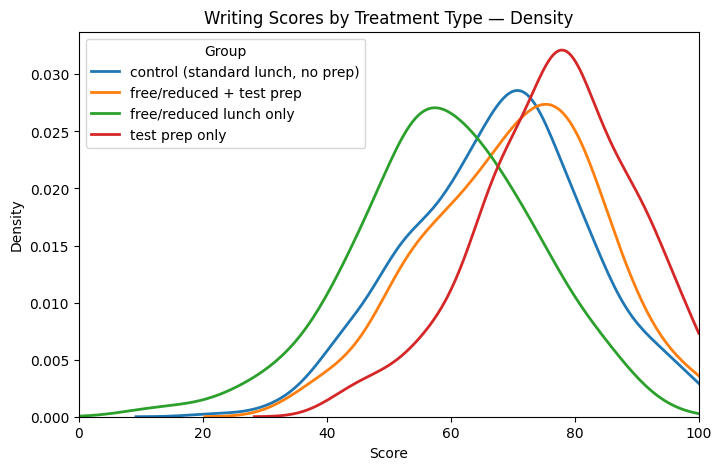

In [27]:
# Density plot to compare writing scores by treatment type
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
for g, sub in writing_by_treatment.groupby("group"):
    sns.kdeplot(sub["score"], label=g, linewidth=2, clip=(0, 100))
plt.title("Writing Scores by Treatment Type — Density")
plt.xlabel("Score"); plt.ylabel("Density")
plt.xlim(0, 100)
plt.legend(title="Group", loc="best")
plt.show()

</br>
</br>
</br>

Each group looks pretty normal , but let's perform some tests to be sure:


In [28]:
# Normality tests per group (Shapiro–Wilk and Lilliefors)

from scipy.stats import shapiro
from statsmodels.stats.diagnostic import lilliefors
import numpy as np
import pandas as pd

rows = []
for g, sub in writing_by_treatment.groupby("group"):
    x = sub["score"].dropna().to_numpy()
    n = len(x)

    # Shapiro–Wilk (works best for n <= 5000)
    sh_stat, sh_p = shapiro(x) if n >= 3 else (np.nan, np.nan)

    # Lilliefors (normality with estimated parameters)
    try:
        lf_stat, lf_p = lilliefors(x, dist="norm")
    except Exception:
        lf_stat, lf_p = (np.nan, np.nan)

    rows.append((g, n, x.mean(), x.std(ddof=1), sh_stat, sh_p, lf_stat, lf_p))

norm_table = pd.DataFrame(
    rows,
    columns=["group", "n", "mean", "sd", "shapiro_stat", "shapiro_p", "lilliefors_stat", "lilliefors_p"]
)

display(norm_table)

,group,n,mean,sd,shapiro_stat,shapiro_p,lilliefors_stat,lilliefors_p
0,"control (standard lunch, no prep)",418,67.595694,14.238182,0.994477,0.137171,0.047907,0.024284
1,free/reduced + test prep,131,70.351145,13.850256,0.988577,0.351882,0.062406,0.301467
2,free/reduced lunch only,224,58.736607,14.707226,0.991223,0.196900,0.046673,0.317217
3,test prep only,227,76.766520,12.535017,0.982888,0.007629,0.061523,0.046483


**Normality is checked for each treatment group!**

- Similarity of variances

In [29]:
# Variance similarity (rough rule) + Bartlett and Fligner–Killeen tests
import numpy as np
from scipy import stats

# Rough rule: max(var) / min(var) < 2 → similar variances
group_vars = writing_by_treatment.groupby("group")["score"].var(ddof=1)
ratio_max_min = group_vars.max() / group_vars.min()
print("Group variances:\n", group_vars)
print(f"Max/Min variance ratio = {ratio_max_min:.3f}  (rule-of-thumb < 2.0 suggests similar variances)")

# Prepare arrays for omnibus variance tests
groups = [sub["score"].dropna().to_numpy() for _, sub in writing_by_treatment.groupby("group")]

# Bartlett (sensitive to non-normality) and Fligner (robust)
bart_stat, bart_p = stats.bartlett(*groups)
flig_stat, flig_p = stats.fligner(*groups)

print(f"Bartlett test        : stat={bart_stat:.3f}, p={bart_p:.4f}")
print(f"Fligner–Killeen test : stat={flig_stat:.3f}, p={flig_p:.4f}")

Group variances:
 group
control (standard lunch, no prep)    202.725833
free/reduced + test prep             191.829595
free/reduced lunch only              216.302510
test prep only                       157.126662
Name: score, dtype: float64
Max/Min variance ratio = 1.377  (rule-of-thumb < 2.0 suggests similar variances)
Bartlett test        : stat=6.461, p=0.0912
Fligner–Killeen test : stat=5.678, p=0.1284


**Homogeneity of variances of treatment groups is checked!** ( both with a rough rule and with actual tests.)

We can finally perform ANOVA:

In [30]:
# One-way ANOVA for writing scores across treatment groups

from scipy.stats import f_oneway
import numpy as np
import pandas as pd

# Reuse 'groups' built above
F, p = f_oneway(*groups)
print(f"One-way ANOVA: F = {F:.3f}, p = {p:.4e}")

# Optional: effect size (eta-squared)
all_scores = writing_by_treatment["score"].to_numpy()
grand_mean = all_scores.mean()
ss_between = sum(
    len(sub) * (sub["score"].mean() - grand_mean) ** 2
    for _, sub in writing_by_treatment.groupby("group")
)
ss_total = ((all_scores - grand_mean) ** 2).sum()
eta_sq = ss_between / ss_total
print(f"Eta-squared (η²) = {eta_sq:.3f}")

# Context: group sample sizes and means
summary = writing_by_treatment.groupby("group")["score"].agg(["count", "mean", "std"])
display(summary)

One-way ANOVA: F = 64.359, p = 4.8672e-38
Eta-squared (η²) = 0.162


,count,mean,std
group,,,
"control (standard lunch, no prep)",418,67.595694,14.238182
free/reduced + test prep,131,70.351145,13.850256
free/reduced lunch only,224,58.736607,14.707226
test prep only,227,76.766520,12.535017


### Key takeaways:


- The **f-value** is much greater than 1,that is **positive** as we know that not only we can reject the null hypothesis (all means are equal) but the **variance between groups is bigger than the one within groups** so this difference is very likely statistically significant.

- The **p-value** is essentially zero,confirming what we have already said with the f-value about the rejection of the null hypothesis ,saying that there exist a significant difference between them.


### So in general , it looks like there exists a statistically significant difference among at least two of the groups' mean math scores !

But wait... which couples of means are different from each other?

To answer this question we must perform a post-hoc test.

### Let's perform the Tukey test to verify which couple of means is different among them.

### Key takeaways:

- As the boxplot already showed , the difference in means between treatment 1 and control , with control group having higher math scores , is significant: **it looks like having the economic freedom of not paying or paying less for lunch negatively impats math scores!**

- Another important difference already present in the boxplot , the difference in means between treatment 2 and 1 , with treatment 2 having higher math scores , is significant:  **only attending the test preparation course and not having the economic freedom of the free or reduced lunch is more effective than having that economic freedom and not attending the test preparation course!**

- This difference was also present in the boxplot , like the other two , and is between the third and second treatments, with treatment two being more effective than the third.
This means that : **the people who attended the test preparation course but also enjoyed the economic freedom of the free/reduced lunch , statistically perform worse than people who have attened the test , but have to pay for lunch**.

### Conclusions : from these tests it looks like , while on the one hand saving the lunch money has a negative effect on math scores as opposed as we expected , on the other hand attending the test preparation course has a positive one as we expected.

### Maybe people used the money saved from lunch to buy things that distracted them from studying maths! That's not good , buy more math books with that money!





                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
              group1                       group2          meandiff p-adj   lower    upper  reject
--------------------------------------------------------------------------------------------------
control (standard lunch, no prep) free/reduced + test prep   2.7555 0.1978  -0.8335  6.3444  False
control (standard lunch, no prep)  free/reduced lunch only  -8.8591    0.0  -11.827 -5.8911   True
control (standard lunch, no prep)           test prep only   9.1708    0.0   6.2157  12.126   True
         free/reduced + test prep  free/reduced lunch only -11.6145    0.0 -15.5569 -7.6722   True
         free/reduced + test prep           test prep only   6.4154 0.0002   2.4827 10.3481   True
          free/reduced lunch only           test prep only  18.0299    0.0  14.6543 21.4055   True
--------------------------------------------------------------------------------------------------


,group1,group2,meandiff,p-adj,lower,upper,reject
0,"control (standard lunch, no prep)",free/reduced + test prep,2.7555,0.1978,-0.8335,6.3444,False
1,"control (standard lunch, no prep)",free/reduced lunch only,-8.8591,0.0000,-11.8270,-5.8911,True
2,"control (standard lunch, no prep)",test prep only,9.1708,0.0000,6.2157,12.1260,True
3,free/reduced + test prep,free/reduced lunch only,-11.6145,0.0000,-15.5569,-7.6722,True
4,free/reduced + test prep,test prep only,6.4154,0.0002,2.4827,10.3481,True
5,free/reduced lunch only,test prep only,18.0299,0.0000,14.6543,21.4055,True


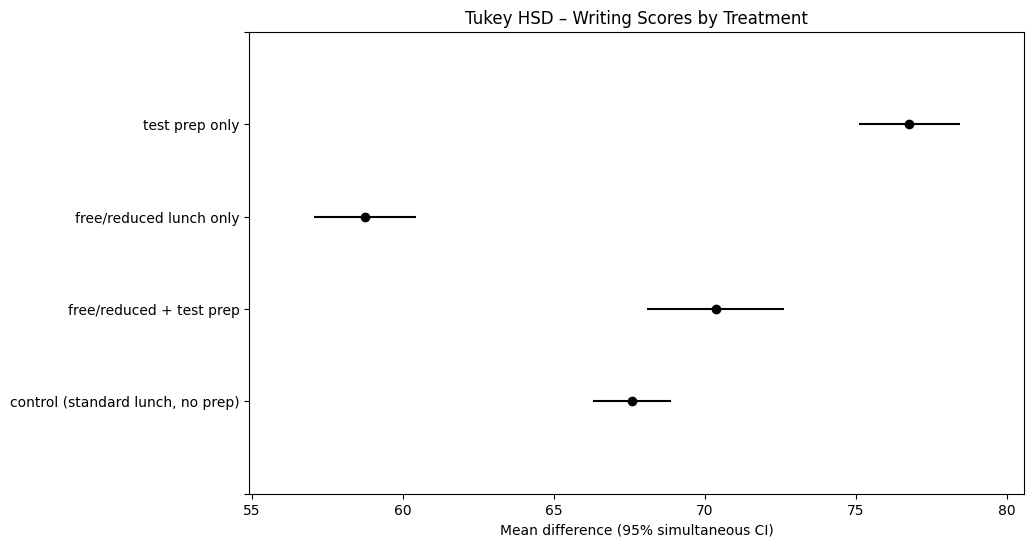

In [31]:
# Tukey HSD post-hoc test across treatment groups (same DV used in ANOVA)

import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Run Tukey on the writing scores by treatment group
tuk = pairwise_tukeyhsd(
    endog=writing_by_treatment["score"],
    groups=writing_by_treatment["group"],
    alpha=0.05
)

print(tuk)

# Tidy summary table
tuk_df = pd.DataFrame(
    tuk._results_table.data[1:],  # skip header row
    columns=tuk._results_table.data[0]
)
display(tuk_df)

# Optional: simultaneous CIs plot
fig = tuk.plot_simultaneous()
plt.title("Tukey HSD – Writing Scores by Treatment")
plt.xlabel("Mean difference (95% simultaneous CI)")
plt.show()

## Conclusion & Interpretation

### 1) Gender comparisons
- **Math:** After IQR outlier removal, males score **higher** than females  
  *(Levene p≈0.97 → equal variances; one-sided t-test male>female: **t=5.137, p<0.001**; Hedges’ g ≈ **0.33**, small–to–medium).*
- **Reading:** Both groups passed normality (CvM p>0.5). With the prespecified alternative (*female > male*), the one-sided t-test should be used to confirm significance; descriptively, females tend to score higher.

### 2) Treatment effects on **Writing** (ANOVA + Tukey)
We compared four groups:
- **control (standard lunch, no prep)**
- **free/reduced lunch only**
- **test prep only**
- **free/reduced + test prep**

**ANOVA:** Between-group differences are **statistically significant** *(F ≫ 1, p ≈ 0)* — at least two means differ.

**Tukey HSD (FWER = 0.05):**
- **test prep only** > **control** *(p < 0.001)*
- **test prep only** > **free/reduced + test prep** *(p = 0.0002)*
- **test prep only** > **free/reduced lunch only** *(p < 0.001)*
- **free/reduced + test prep** > **free/reduced lunch only** *(p < 0.001)*
- **control** > **free/reduced lunch only** *(p < 0.001)*
- **control** vs **free/reduced + test prep**: **not significant** *(p ≈ 0.198)*

**Mean ranking (highest → lowest):**  
**test prep only** → **free/reduced + test prep ≈ control** → **free/reduced lunch only**.

### 3) Practical takeaways
- Taking a **test-preparation course** is associated with the **largest improvement** in writing scores.
- **Free/reduced lunch alone** is associated with the **lowest** writing performance.
- Adding **test prep** to **free/reduced lunch** improves outcomes but still **does not match** the **test-prep-only** group.

### 4) Assumptions & caveats
- Normality checks were acceptable (using CvM/Lilliefors; Box-Cox where needed) and variance diagnostics supported the tests used (Levene/Fligner/Bartlett).
- This is an **observational** dataset: results show **associations**, not causality.

**Bottom line:**  
- **Math:** evidence favors **males > females** (small–medium effect).  
- **Reading:** females tend to perform better; confirm with the one-sided t-test.  
- **Writing:** **test preparation** matters most; **free/reduced lunch only** corresponds to the weakest performance.